In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data_file = open( "AOD_PV.pkl", "rb" )
data = pickle.load( data_file )
data_file.close()
data.keys()

dict_keys(['offlinePrimaryVerticesWithBS', 'genParticles', 'sortedPrimaryVertices', 'offlinePrimaryVertices'])

### Sort dict into plottable format

In [4]:
x = { key: [] for key in data }
y = { key: [] for key in data }
z = { key: [] for key in data }

for key in data:
    for event in data[ key ]:
        x[ key ].append( data[key][event][0][0] )
        y[ key ].append( data[key][event][0][1] )
        z[ key ].append( data[key][event][0][2] )

### 1-D plots of the $z$-coordinate
`offlinePrimaryVerticesWithBS` = Reconstructed primary vertices with the Beam Spot \
`genParticles` = Monte Carlo generated particles \
`sortedPrimaryVertices` = Reconstructed primary vertices sorted according to [this presentation](https://indico.cern.ch/event/369417/contributions/1788757/attachments/734933/1008272/pv-sorting-xpog.pdf) \
`offlinePrimaryVertices` = Reconstructed primary vertices sorted by the sum of $p_T^2$ for the tracks used in the PV fit

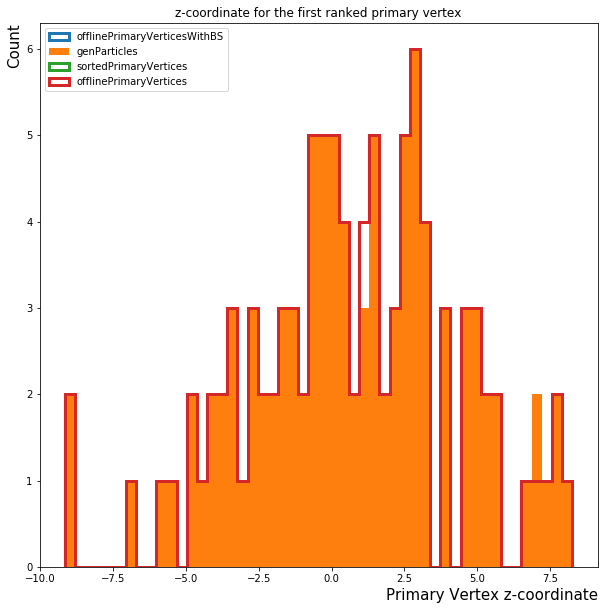

In [5]:
plt.figure( figsize = (10,10) )
for key in z:
    histtype = "step"
    if key == "genParticles": 
        histtype = "stepfilled"
    plt.hist(
        np.asarray( z[ key ] ),
        label = str(key),
        histtype = histtype,
        linewidth = 3,
        bins = 50
    )
plt.legend( loc = 2 )
plt.title( "z-coordinate for the first ranked primary vertex")
plt.ylabel( "Count", y = 1.0, ha = "right", fontsize = 15 )
plt.xlabel( "Primary Vertex z-coordinate", x = 1.0, ha = "right", fontsize = 15 )
plt.show()

### Histogram of the `offlinePrimaryVertices` and `offlinePrimaryVerticesWithBS` coordinate differential

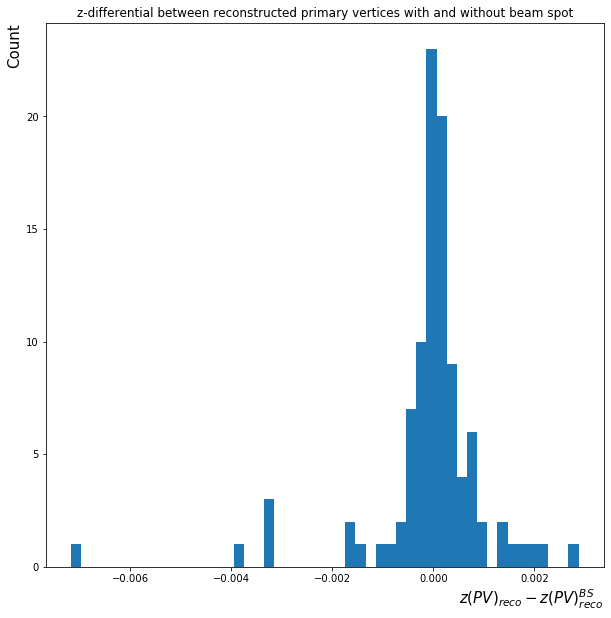

In [6]:
plt.figure( figsize = (10,10) )
plt.hist(
    np.array( z["offlinePrimaryVertices"] ) - np.array( z["offlinePrimaryVerticesWithBS"] ),
    bins = 50
)
plt.title( "z-differential between reconstructed primary vertices with and without beam spot")
plt.ylabel( "Count", y = 1.0, ha = "right", fontsize = 15 )
plt.xlabel( r"$z(PV)_{reco}-z(PV)^{BS}_{reco}$", x = 1.0, ha = "right", fontsize = 15 )
plt.show()

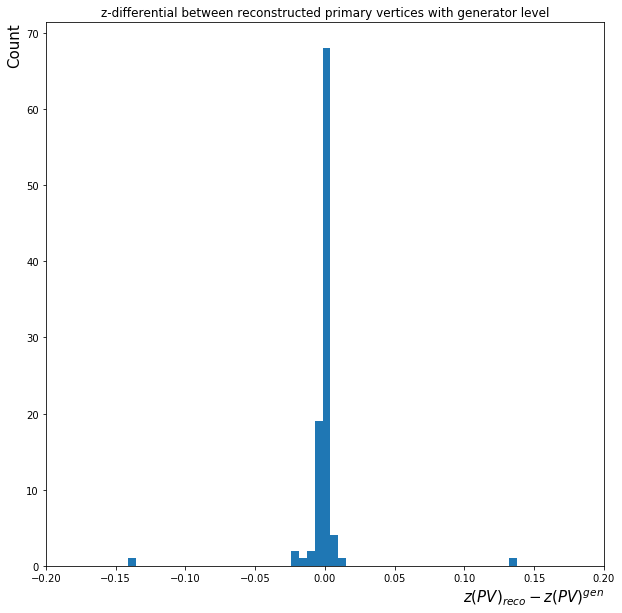

In [11]:
plt.figure( figsize = (10,10) )
plt.hist(
    np.array( z["offlinePrimaryVertices"] ) - np.array( z["genParticles"] ),
    bins = 1000
)
plt.title( "z-differential between reconstructed primary vertices with generator level")
plt.ylabel( "Count", y = 1.0, ha = "right", fontsize = 15 )
plt.xlabel( r"$z(PV)_{reco}-z(PV)^{gen}$", x = 1.0, ha = "right", fontsize = 15 )
plt.xlim(-0.2,0.2)
plt.show()

### Plot a 2-D density map of the $z$-coordinate and the transverse projection from the beam spot

In [12]:
projection = {
    "offlinePrimaryVerticesWithBS": [],
    "genParticles": []
}

for key in projection:
    for i in range( len( x[ key ] ) ):
        projection[ key ].append( np.sqrt( x[ key ][i]**2 + y[ key ][i]**2 ) )

Generator-level Particle Primary Vertices

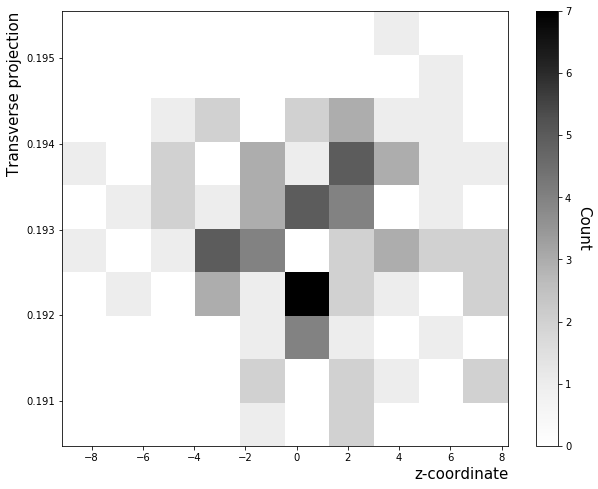

In [13]:
plt.figure( figsize = (10,8) )
plt.hist2d(
    z[ "genParticles" ], projection[ "genParticles" ],
    bins = (10,10),
    cmap = plt.cm.Greys
)
plt.xlabel( "z-coordinate", x = 1.0, ha = "right", fontsize = 15 )
plt.ylabel( "Transverse projection", y = 1.0, ha = "right", fontsize = 15 )
cbar = plt.colorbar()
cbar.set_label( "Count", fontsize = 15, rotation = 270, labelpad = 20 )
plt.show()

Offline Reconstructed Primary Vertices with Beam Spot

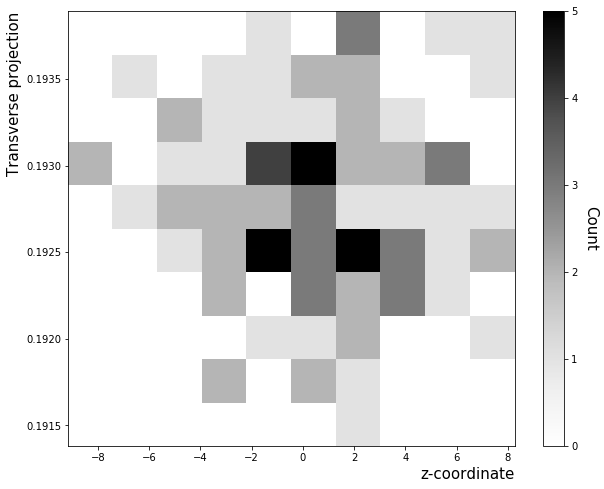

In [75]:
plt.figure( figsize = (10,8) )
plt.hist2d(
    z[ "offlinePrimaryVerticesWithBS" ], projection[ "offlinePrimaryVerticesWithBS" ],
    bins = (10,10),
    cmap = plt.cm.Greys
)
plt.xlabel( "z-coordinate", x = 1.0, ha = "right", fontsize = 15 )
plt.ylabel( "Transverse projection", y = 1.0, ha = "right", fontsize = 15 )
cbar = plt.colorbar()
cbar.set_label( "Count", fontsize = 15, rotation = 270, labelpad = 20 )
plt.show()

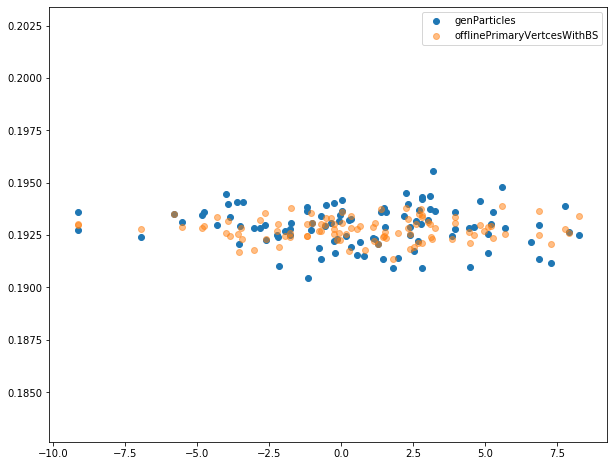

In [17]:
plt.figure( figsize = (10,8) )
plt.scatter(z[ "genParticles" ], projection[ "genParticles" ],label="genParticles")
plt.scatter(z[ "offlinePrimaryVerticesWithBS" ], projection[ "offlinePrimaryVerticesWithBS" ],label="offlinePrimaryVertcesWithBS",alpha=0.5)
plt.legend()
plt.show()

## Appendix: Primary Vertex Re-Sorting
Referencing [2015 presentation](https://indico.cern.ch/event/369417/contributions/1788757/attachments/734933/1008272/pv-sorting-xpog.pdf) in which it was introduced and [an addition to CMSSW](https://github.com/cms-sw/cmssw/pull/7285/commits/539197c593270b7515a8b07c1891e3bfcd9fc89c) was made to introduce the new sorting concept. \
The general idea is:
1. Re-assign tracks to a primary vertex (not necessarily the ones used to form the primary vertex)
2. Run a jet-algorithm to cluster objects in jets for each primary vertex
3. Compute the $E^{miss}_T$ for only charged particles for each primary vertex
4. Sum over the $p^{2}_T$ for the clustered objects (rather than per track), including the $E^{miss}_T$ as representative of the neutrals
    * Jets and $E^{miss}_T$ have their $p_T$ down-weighted to account for larger uncertainties relative to leptons: $0.20$ for jets and by $\sqrt{\sum{E_T}}$ for $E^{miss}_T$

The re-sorting algorithm can be run on either PFCandidates or with tracks. However, by running on tracks, the re-sorting can be done immediately after PV production, benefiting the entire reconstruction.  The implementation of the algorithm is handled in three parts:
1. Primary Vertex Assignment: each track is assigned to a PV
2. Primary Vertex Sorting: a score is computed for each PV
3. Compilation: EDProducer puts the sorted collection in the event together with the assignment maps, qualities and old to new remapping